# DSCI 100 - Proposal
### project-003-7: Nicole Campbell, Michelle Kim, Jason Liu, Zahra Raza

## Introduction
A student’s academic performance is often affected by different social and environmental factors. Thus, objective analysis on the relationship between those factors is critical to bolster maximum academic success. 

The topic of our project is centered around a data set which looks at student performance in two different schools located in Portugal. The dataset includes a variety of different factors that could play a role in student performance. The dataset also tracks first and second period grades as well as final grades in subjects Math or Portugese, which can be used to determine the change in student performance.

We will be working with the data set “Student Performance”, collected by Paulo Cortez at the University of Minho. The data set contains information gathered from students at two Portugese secondary students. This information collected includes student grades, social and study habits, and family background.  The data tracks the students’ grades in two subjects, Mathematics and Portuguese. 

We will try to answer the following question in this report:
Can we predict whether a student  pursue higher education given sex, address, parent education, failures, family educational support, and Portuguese grades?


## Preliminary exploratory data analysis

In [33]:
### Run this cell before continuing. 
library(tidyverse)
library(tidymodels)
library(repr)
library(ggplot2)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

In [34]:
#Read data set from the web into R
student_port <- read.table("data/student-por.csv",sep=";",header=TRUE)

# Clean and wrangle data into tidy format
student_select <- student_port %>%
                select("sex", "address", "Medu", "Fedu", "failures", "famsup", "higher", "G1", "G2", "G3") %>%
                mutate(higher = as_factor(higher))

# Obtain training set:
# We chose strata = 0.75 since the data set is large enough that we will still 
# have a reasonable amount of training and testing data with this split.
student_split <- initial_split(student_select, prop = 0.75, strata = higher) 

student_train <- training(student_split)
student_train

,sex,address,Medu,Fedu,failures,famsup,higher,G1,G2,G3
,<chr>,<chr>,<int>,<int>,<int>,<chr>,<fct>,<int>,<int>,<int>
1,F,U,4,4,0,no,yes,0,11,11
2,F,U,1,1,0,yes,yes,9,11,11
3,F,U,1,1,0,no,yes,12,13,12
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
645,F,R,2,3,1,no,yes,10,11,10
646,F,U,3,1,0,yes,yes,15,15,16
648,M,U,3,1,0,no,yes,10,10,10


In [35]:
# number of observations in higher(target variable)
counts <- student_train %>%
        group_by(higher) %>%
        summarize(n=n())   
counts

# average grade of term 1, term 2, and final Portuguese grade
ave_grade <- student_train %>%
            summarize(G1 = mean(G1), G2 = mean(G2), G3 = mean(G3))
ave_grade


`summarise()` ungrouping output (override with `.groups` argument)



higher,n
<fct>,<int>
yes,435
no,52


G1,G2,G3
<dbl>,<dbl>,<dbl>
11.40041,11.57084,11.88706


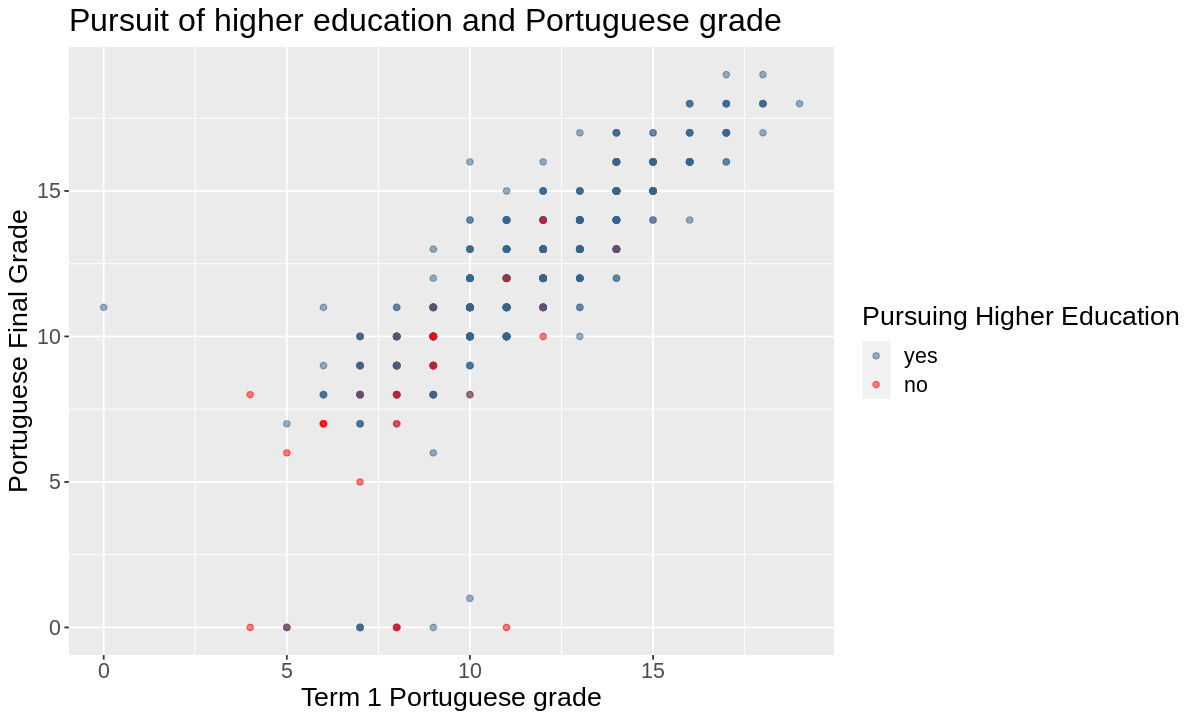

In [79]:
options(repr.plot.width=10, repr.plot.height=6)

# comparing the distribution of Portuguese grades and higher
student_por_plot <- student_train %>%
                select(G1, G3, higher) %>%
                ggplot(aes(x = G1, y = G3, colour = higher)) + 
                geom_point(alpha = 0.5)+
                scale_colour_manual(values = c("yes" = "steelblue4","no"="red")) +
                labs(x = "Term 1 Portuguese grade", y = "Portuguese Final Grade", colour = "Pursuing Higher Education", title = "Pursuit of higher education and Portuguese grade")+
                theme(text = element_text(size=16))        

student_por_plot


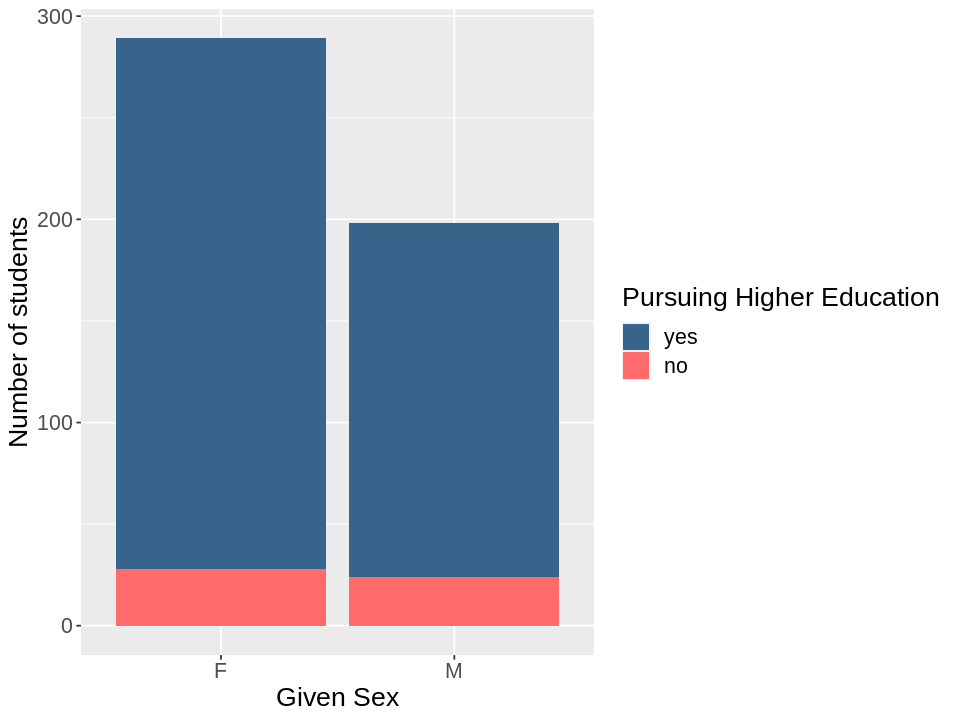

In [70]:
options(repr.plot.width=8, repr.plot.height=6)
student_gender <- student_train %>%
                select(sex, higher) %>%
                ggplot(aes(x=sex, y=higher))+
                geom_bar(aes(y = ..count.., fill = higher))+
                scale_fill_manual(values = c("yes" = "steelblue4","no"="indianred1")) +
                labs(x = "Given Sex", y = "Number of students", fill = "Pursuing Higher Education")+
                theme(text = element_text(size=16))
student_gender

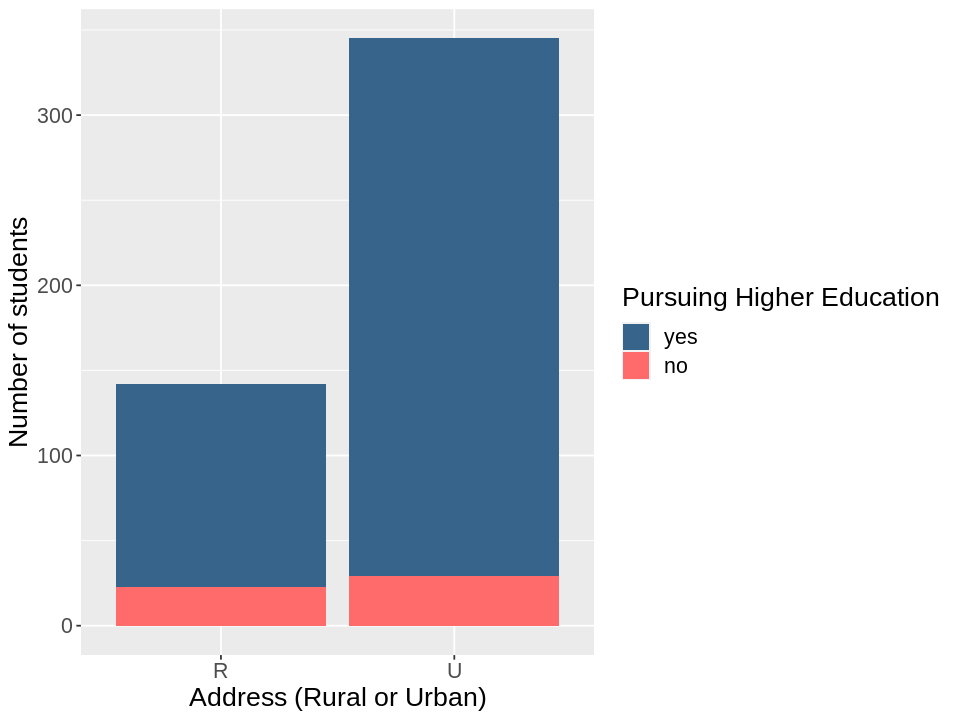

In [72]:
options(repr.plot.width=8, repr.plot.height=6)
student_address <- student_train %>%
                select(address, higher) %>%
                ggplot(aes(x=address, y=higher))+
                geom_bar(aes(y = ..count.., fill = higher))+
                scale_fill_manual(values = c("yes" = "steelblue4","no"="indianred1")) +
                labs(x = "Address (Rural or Urban)", y = "Number of students", fill = "Pursuing Higher Education")+
                theme(text = element_text(size=16))
student_address



`summarise()` regrouping output by 'address' (override with `.groups` argument)



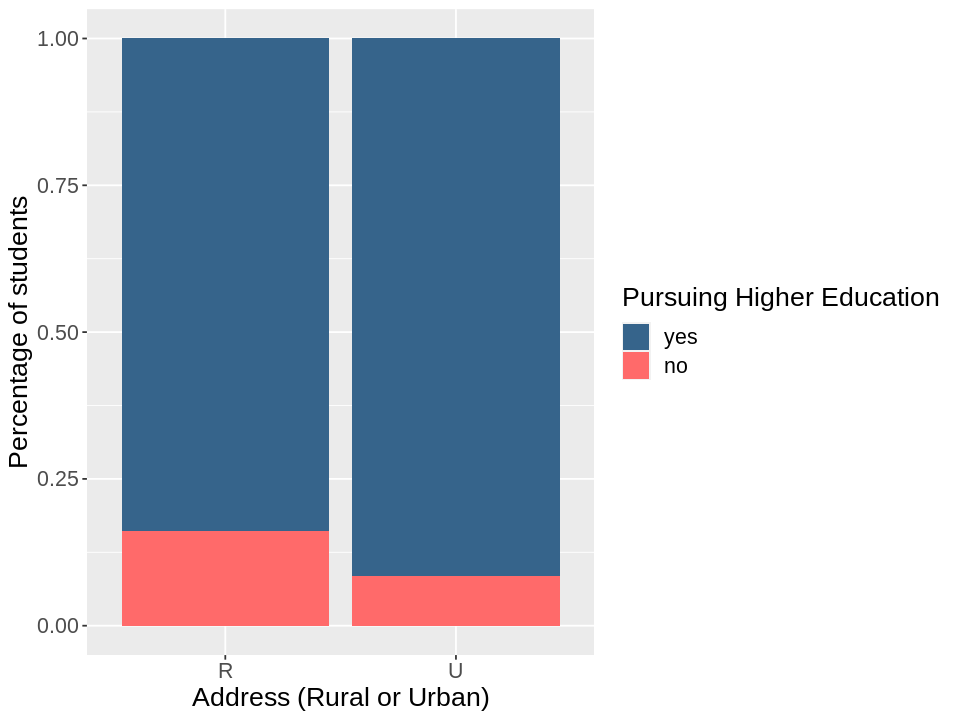

In [73]:
address_n_higher <- student_train %>%
            select(address, higher)%>%
            group_by(address, higher)%>%
            summarize(n = n())
address_plot <- ggplot(address_n_higher, aes(x = address, y = n, fill = higher)) +
                    geom_bar(stat = "identity", position = "fill")+
                scale_fill_manual(values = c("yes" = "steelblue4","no"="indianred1")) +
                labs(x = "Address (Rural or Urban)", y = "Percentage of students", fill = "Pursuing Higher Education")+
                theme(text = element_text(size=16))
address_plot

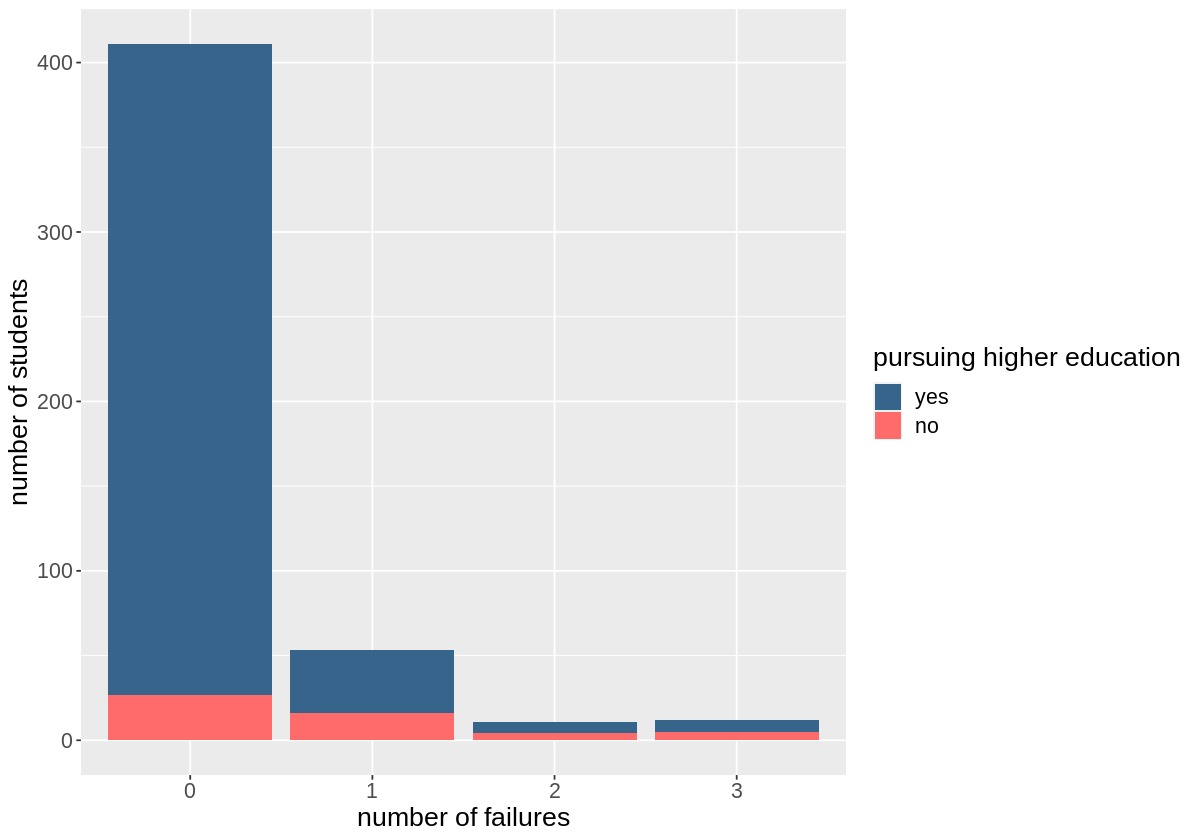

In [74]:
options(repr.plot.width=10, repr.plot.height=7)
student_failures <- student_train %>%
                select(failures, higher) %>%
                ggplot(aes(x=as.factor(failures), y=higher))+
                geom_bar(aes(y = ..count.., fill = higher))+
                scale_fill_manual(values = c("yes" = "steelblue4","no"="indianred1")) +
                labs(y = "number of students", x = "number of failures", fill = "pursuing higher education")+
                theme(text = element_text(size=16))
student_failures

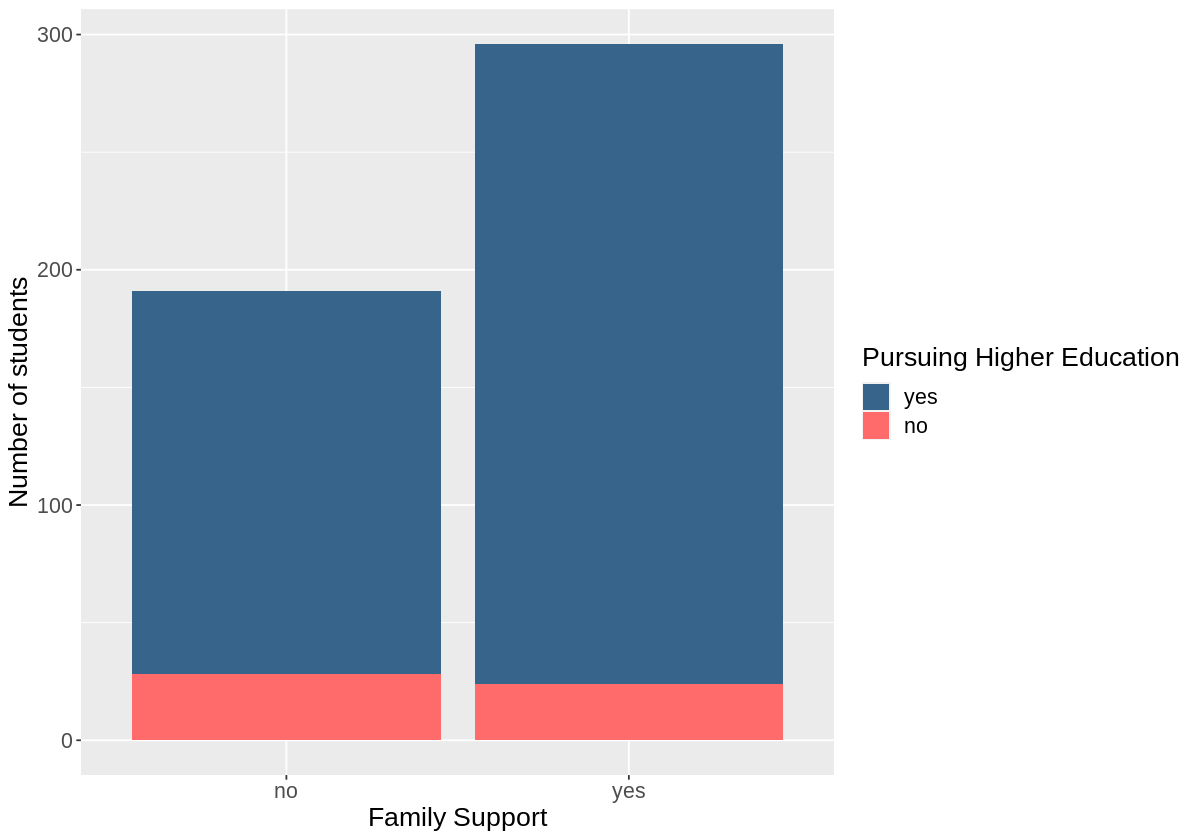

In [75]:
family_support <- student_train %>%
                select(famsup, higher) %>%
                ggplot(aes(x=famsup, y=higher))+
                geom_bar(aes(y = ..count.., fill = higher))+
                scale_fill_manual(values = c("yes" = "steelblue4","no"="indianred1")) +
                labs(x = "Family Support", y = "Number of students", fill = "Pursuing Higher Education")+
                theme(text = element_text(size=16))
family_support

## Methods

In order to create our prediction model, we will be looking at seven predictor variables: given sex, address (rural or urban), parents’ education, number of previous class failures, family educational support, and Portuguese course grades. 

First, we wanted to  visualize the effect of a student’s grades on their choice to pursue higher education. We created a graph of each student’s Period 1 Portuguese grade vs. Final Portuguese grade and coloured the data points by the variable “higher”. This allows us to see the distribution of “higher” with respect to grades. 
We also wanted to visualize the distribution of our target variable with respect to the other categorical values. We created three bar graphs that show the number of students of students choosing yes or no depending on given sex, rural or urban address, and number of previous class failures.
